Resources for analysis

* https://bioinformaticsworkbook.org/tutorials/wgcna.html#gsc.tab=0

## Set Library Path

In [1]:
.libPaths("/home/vhaghani/anaconda3/envs/jupyter_nb_R4.4.2/lib/R/library")

## Load Libraries

In [3]:
library(tidyverse)
library(WGCNA)
library(magrittr)
library(biomaRt)
library(dplyr)

## Load Data

In [4]:
# Read in normalized gene counts from DEG analysis
counts <- read.delim("05_gene_counts/normalized_counts.txt", row.names = 1)

# View data
head(counts)

,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000051285,5.8623556,5.8214049,5.8496721,5.8134141,5.7206892,5.333852,5.8048422,5.8525708,5.58872075,5.7749417,5.8035582,5.8083393,5.6783630,5.8486219,5.6227960,5.9566247
ENSMUSG00000103509,0.2983516,-1.5044228,-1.6538007,-1.1879393,0.8361266,-2.590010,0.4316992,0.6636771,-0.08022876,0.8915903,0.2430641,-1.9766896,-0.5350123,0.2614967,-2.5900101,-0.5017600
ENSMUSG00000097797,0.9140247,0.6452259,0.3829039,0.6767366,1.0008217,1.045641,1.2532123,0.5208986,0.19012609,0.5571165,0.2430641,0.3894827,0.7976682,0.5789491,0.4848330,0.2096132
ENSMUSG00000026312,3.3547184,3.7034065,3.7728273,3.3300863,3.8815256,4.056796,3.6704622,3.5434458,5.03226389,4.0190677,3.4439909,4.6013811,4.1602418,2.9007806,3.8144665,3.2926257
ENSMUSG00000039748,0.3912817,0.8076605,1.0965376,0.7948876,1.2826872,1.573093,0.8418504,1.9900025,1.58156492,1.0063180,1.3058155,0.0648287,0.7079450,1.4582125,0.6992561,0.8371884
ENSMUSG00000057363,4.5333998,4.7993203,4.7437552,4.7313907,5.0529841,5.965852,5.1824331,4.6831706,4.71645089,4.6374297,4.4054985,4.0317310,4.2344181,4.5843911,4.4241977,4.4797900


## Confirm Data Normalization

In [ ]:
# Convert row names to a column
counts$GeneId <- rownames(counts)

# Reset row names
rownames(counts) <- NULL

# Reorder columns so that "GeneId" is the first column
counts <- counts[, c("GeneId", names(counts)[-ncol(counts)])]

# View
head(counts)

In [ ]:
# Transpose the dataframe into longer format

# Get all but first column name
col_sel <- names(counts)[-1]     

# Transpose
mdata <- counts %>%
  pivot_longer(
    cols = col_sel,
    names_to = "name",
    values_to = "value"
  ) %>%  
  mutate(
    group = substr(name, 1, 2)
  )

# View 
head(mdata)

In [ ]:
# Order groups for plot
mdata$group <- factor(mdata$group,
                      levels = c("G1", "G2"))

pdf("06_WGCNA/fae_vs_control_normalized_expression_violin_plots.pdf", height = 10, width = 10)

# Plot groups (Sample Groups vs RNA Seq Counts) to identify outliers
p <- mdata %>%
    ggplot(aes(x = name, y = value)) +             
    geom_violin() +                                   
    geom_point(alpha = 0.2) +                       
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 90)          
    ) +
    labs(x = "Treatment Groups", y = "Normalized RNA Seq Counts") +
    facet_grid(cols = vars(group), drop = TRUE, scales = "free_x")

p

dev.off()

## WGCNA

### Read in Count Data

In [5]:
# Read in normalized gene counts from DEG analysis
counts <- read.delim("05_gene_counts/normalized_counts.txt", row.names = 1)

# View data
head(counts)

,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000051285,5.8623556,5.8214049,5.8496721,5.8134141,5.7206892,5.333852,5.8048422,5.8525708,5.58872075,5.7749417,5.8035582,5.8083393,5.6783630,5.8486219,5.6227960,5.9566247
ENSMUSG00000103509,0.2983516,-1.5044228,-1.6538007,-1.1879393,0.8361266,-2.590010,0.4316992,0.6636771,-0.08022876,0.8915903,0.2430641,-1.9766896,-0.5350123,0.2614967,-2.5900101,-0.5017600
ENSMUSG00000097797,0.9140247,0.6452259,0.3829039,0.6767366,1.0008217,1.045641,1.2532123,0.5208986,0.19012609,0.5571165,0.2430641,0.3894827,0.7976682,0.5789491,0.4848330,0.2096132
ENSMUSG00000026312,3.3547184,3.7034065,3.7728273,3.3300863,3.8815256,4.056796,3.6704622,3.5434458,5.03226389,4.0190677,3.4439909,4.6013811,4.1602418,2.9007806,3.8144665,3.2926257
ENSMUSG00000039748,0.3912817,0.8076605,1.0965376,0.7948876,1.2826872,1.573093,0.8418504,1.9900025,1.58156492,1.0063180,1.3058155,0.0648287,0.7079450,1.4582125,0.6992561,0.8371884
ENSMUSG00000057363,4.5333998,4.7993203,4.7437552,4.7313907,5.0529841,5.965852,5.1824331,4.6831706,4.71645089,4.6374297,4.4054985,4.0317310,4.2344181,4.5843911,4.4241977,4.4797900


In [6]:
# Transpose for WGCNA
counts <- t(counts)

head(counts)

,ENSMUSG00000051285,ENSMUSG00000103509,ENSMUSG00000097797,ENSMUSG00000026312,ENSMUSG00000039748,ENSMUSG00000057363,ENSMUSG00000038702,ENSMUSG00000100515,ENSMUSG00000033021,ENSMUSG00000055214,⋯,ENSMUSG00000064358,ENSMUSG00000064363,ENSMUSG00000064367,ENSMUSG00000064368,ENSMUSG00000064369,ENSMUSG00000064370,ENSMUSG00000064371,ENSMUSG00000064372,ENSMUSG00000095041,ENSMUSG00000095742
G1_1_1_4,5.862356,0.2983516,0.9140247,3.354718,0.3912817,4.533400,4.109893,0.4785863,4.973664,-1.280884296,⋯,2.455322,9.651863,10.501845,8.684080,4.143676,11.11571,0.638784397,4.411123,7.471423,3.307809
G1_1_1_5,5.821405,-1.5044228,0.6452259,3.703406,0.8076605,4.799320,3.923169,0.3610993,4.558121,0.006943263,⋯,2.741923,9.487347,10.152474,8.187756,3.850465,10.87664,0.006943263,4.289118,6.834680,3.887275
G1_1_1_6,5.849672,-1.6538007,0.3829039,3.772827,1.0965376,4.743755,3.953221,-0.6867860,4.780057,-0.520572975,⋯,2.190894,9.506349,10.308329,8.272462,4.001851,10.86935,0.614982823,4.138615,6.718446,4.430166
G1_1_1_7,5.813414,-1.1879393,0.6767366,3.330086,0.7948876,4.731391,3.986835,0.7948876,4.879151,0.164839516,⋯,2.559694,9.565131,10.102755,8.323810,3.903801,10.88876,1.189433525,4.663118,7.068253,4.226472
G1_1_2_4,5.720689,0.8361266,1.0008217,3.881526,1.2826872,5.052984,4.219136,-0.2973407,4.751480,0.185973359,⋯,2.199061,9.168697,9.780332,7.847393,3.223632,10.56855,0.920823063,4.443273,6.989919,3.943569
G1_1_2_5,5.333852,-2.5900101,1.0456410,4.056796,1.5730927,5.965852,4.259127,-0.2354227,4.304182,0.542861937,⋯,2.239325,8.702100,9.145384,7.705564,2.284993,10.30368,1.333338408,4.960914,6.591600,4.585411


### Set Up Metadata

In [7]:
# Extract sample names and initialize data frame with conditions
samples <- as.character(rownames(counts))
metadata <- data.frame(samples)
metadata$Control_vs_FA <- c(0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
metadata$Treatment <- c("Control", "Control", "Control", "Control", "Control", "Control", "Control", "FA", "FA", "FA", "FA", "FA", "FA", "FA", "FA", "FA")
metadata$Sex <- c("Female", "Female", "Male", "Male", "Male", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Male", "Male", "Male", "Female")
metadata$Male <- c(0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0)
metadata$Female <- c(1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1)

# Initialize columns for pairwise comparisons
metadata$ControlFemale_vs_FAFemale <- NA
metadata$ControlMale_vs_FAMale <- NA
metadata$FAFemale_vs_FAMale <- NA
metadata$ControlFemale_vs_ControlMale <- NA
metadata$Litter <- NA

# Assign values for ControlFemale_vs_FAFemale
metadata$ControlFemale_vs_FAFemale[metadata$Treatment == "Control" & metadata$Sex == "Female"] <- 0
metadata$ControlFemale_vs_FAFemale[metadata$Treatment == "FA" & metadata$Sex == "Female"] <- 1

# Assign values for ControlMale_vs_FAMale
metadata$ControlMale_vs_FAMale[metadata$Treatment == "Control" & metadata$Sex == "Male"] <- 0
metadata$ControlMale_vs_FAMale[metadata$Treatment == "FA" & metadata$Sex == "Male"] <- 1

# Assign values for FAFemale_vs_FAMale
metadata$FAFemale_vs_FAMale[metadata$Treatment == "FA" & metadata$Sex == "Female"] <- 0
metadata$FAFemale_vs_FAMale[metadata$Treatment == "FA" & metadata$Sex == "Male"] <- 1

# Assign values for ControlFemale_vs_ControlMale
metadata$ControlFemale_vs_ControlMale[metadata$Treatment == "Control" & metadata$Sex == "Female"] <- 0
metadata$ControlFemale_vs_ControlMale[metadata$Treatment == "Control" & metadata$Sex == "Male"] <- 1

# Set row names
row.names(metadata) <- metadata$samples

# Assign values for litter
litter <- sapply(strsplit(rownames(metadata), "_"), function(x) x[3])
metadata$Litter[litter == "1"] <- 0
metadata$Litter[litter == "2"] <- 1
metadata$Litter[litter == "6"] <- 2
metadata$Litter[litter == "7"] <- 3

# Delete residual column
metadata$samples <- NULL

metadata

,Control_vs_FA,Treatment,Sex,Male,Female,ControlFemale_vs_FAFemale,ControlMale_vs_FAMale,FAFemale_vs_FAMale,ControlFemale_vs_ControlMale,Litter
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G1_1_1_4,0,Control,Female,0,1,0,NA,NA,0,0
G1_1_1_5,0,Control,Female,0,1,0,NA,NA,0,0
G1_1_1_6,0,Control,Male,1,0,NA,0,NA,1,0
G1_1_1_7,0,Control,Male,1,0,NA,0,NA,1,0
G1_1_2_4,0,Control,Male,1,0,NA,0,NA,1,1
G1_1_2_5,0,Control,Female,0,1,0,NA,NA,0,1
G1_1_2_6,0,Control,Female,0,1,0,NA,NA,0,1
G2_2_6_5,1,FA,Female,0,1,1,NA,0,NA,2
G2_2_6_6,1,FA,Female,0,1,1,NA,0,NA,2


### Soft Power Threshold

In [8]:
# Allow multi-threading
allowWGCNAThreads() 

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 25, by = 1))

# Call the network topology analysis function
sft = pickSoftThreshold(
  counts,             
  #blockSize = 30,
  powerVector = powers,
  verbose = 5,
  networkType = "signed",
  )

Allowing multi-threading with up to 20 threads.
pickSoftThreshold: will use block size 2589.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2589 of 17279
   ..working on genes 2590 through 5178 of 17279
   ..working on genes 5179 through 7767 of 17279
   ..working on genes 7768 through 10356 of 17279
   ..working on genes 10357 through 12945 of 17279
   ..working on genes 12946 through 15534 of 17279
   ..working on genes 15535 through 17279 of 17279
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.01030  8.800          0.946  8650.0    8650.0   8910
2      2  0.04580  3.300          0.928  4950.0    4940.0   5610
3      3  0.01170  0.669          0.865  3110.0    3090.0   4020
4      4  0.00121 -0.117          0.863  2080.0    2050.0   3080
5      5  0.03530 -0.425          0.877  1460.0    1430.0   2460
6      6  0.12700 -0.619          0.899  1070.0    1030.0   2030
7      7  0.25500 -0.756          0.918 

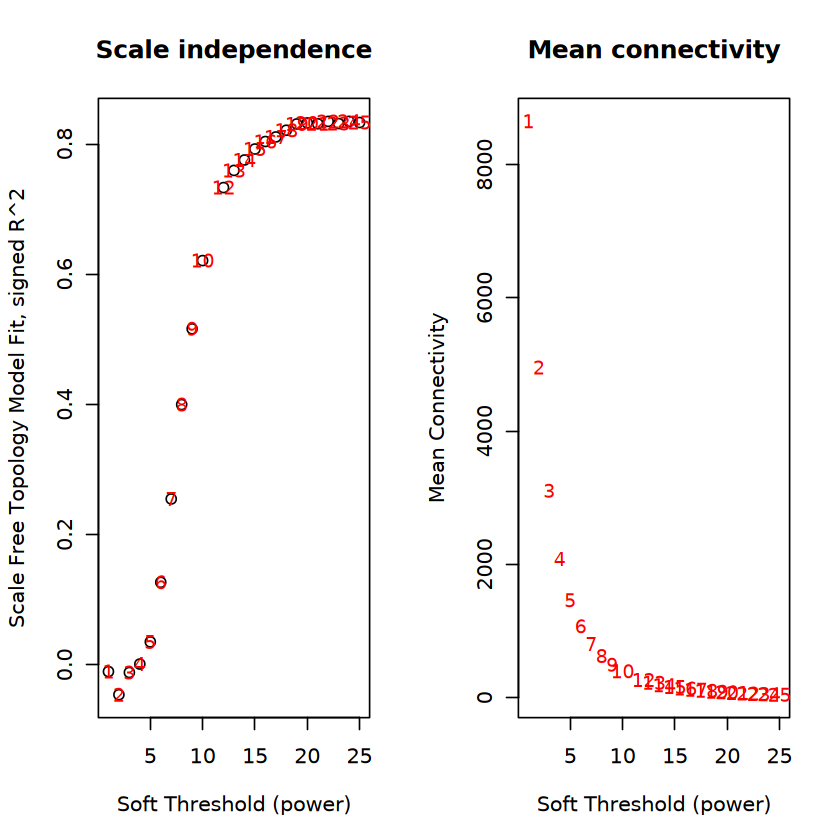

In [9]:
# Plot soft power thresholds

par(mfrow = c(1,2));
cex1 = 0.9;

plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft Threshold (power)",
     ylab = "Scale Free Topology Model Fit, signed R^2",
     main = paste("Scale independence")
)
text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Soft Threshold (power)",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

### Module Generation

Pick a soft threshold power where the SFT.R.sq is above 0.8. Looking at the output of sft, we see that this is 17.

In [10]:
# Build Modules

picked_power = 17
temp_cor <- cor       
cor <- WGCNA::cor # Force it to use WGCNA cor function (fix a namespace conflict issue)

netwk <- blockwiseModules(counts,

                          # Other options
                          maxPOutliers = 0.1,
                          TOMType = "signed",
                          networkCalibration = "full quantile",
                          saveConsensusTOMs = TRUE,

                          # == Adjacency Function ==
                          power = picked_power,                
                          networkType = "signed",

                          # == Tree and Block Options ==
                          deepSplit = 3,
                          pamRespectsDendro = F,
                          # detectCutHeight = 0.75,
                          minModuleSize = 30, # Affects network generation (minimum genes per module, can increase to decrease modules or vice versa)
                          maxBlockSize = 4000, # Primarily to control RAM usage

                          # == Module Adjustments ==
                          reassignThreshold = 0,
                          mergeCutHeight = 0.25,

                          # == TOM == Archive the run results in TOM file (saves time)
                          saveTOMs = T,
                          saveTOMFileBase = "ER",

                          # == Output Options
                          numericLabels = T,
                          verbose = 3)

cor <- temp_cor # Return cor function to original namespace

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4    5 
3998 3989 3916 3825 1551 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 20 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 19 genes from module 1 because their KME is too low.
     ..removing 16 genes from module 2 because their KME is too low.
     ..removing 13 genes from module 3 because their KME is too low.
     ..removing 2 genes from module 4 because their KME

In [11]:
# Convert numeric module labels to module colors
mergedColors = labels2colors(netwk$colors)

# View module distribution as a table (number of genes per module)
module_dist <- as.data.frame(table(mergedColors) %>% sort(decreasing = TRUE))
colnames(module_dist) <- c("Module", "Genes")
head(module_dist)

# Number of modules
length(rownames(module_dist))

# Save output
write.csv(module_dist,"06_WGCNA/gene_module_distribution.csv")

,Module,Genes
,<fct>,<int>
1,turquoise,2635
2,blue,2557
3,brown,1765
4,yellow,1254
5,green,960
6,red,945


[1] 45

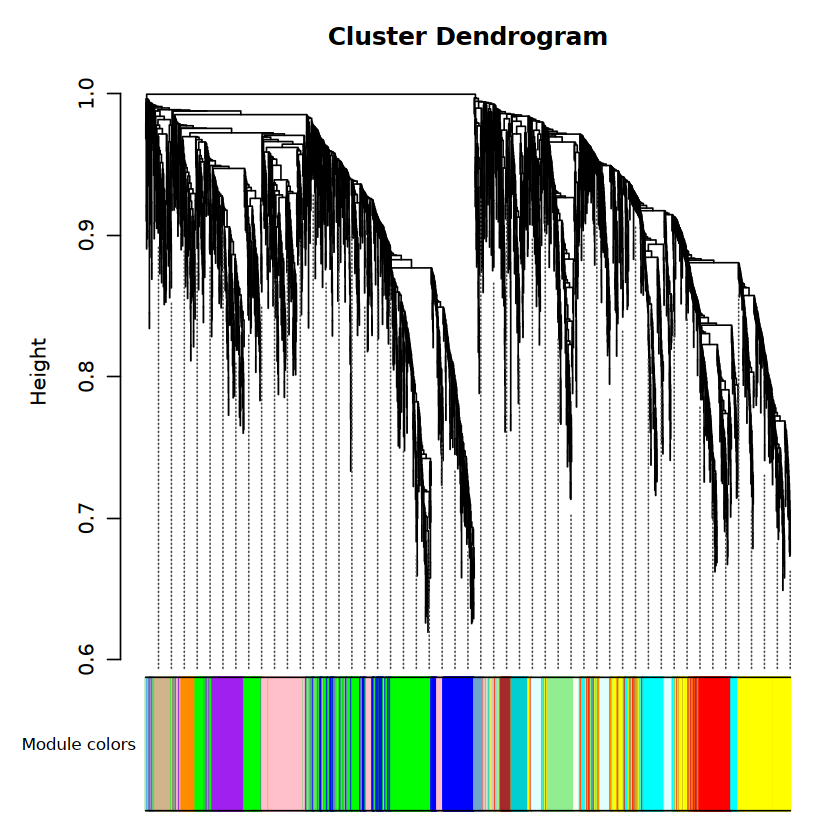

In [12]:
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )

In [13]:
# Pull out list of modules
module_df <- data.frame(
  gene_id = names(netwk$colors),
  colors = labels2colors(netwk$colors)
)

head(module_df)

,gene_id,colors
,<chr>,<chr>
1,ENSMUSG00000051285,royalblue
2,ENSMUSG00000103509,pink
3,ENSMUSG00000097797,black
4,ENSMUSG00000026312,red
5,ENSMUSG00000039748,green
6,ENSMUSG00000057363,turquoise


In [14]:
# Save modules
write_delim(module_df, file = "06_WGCNA/gene_modules.txt", delim = "\t")

### Module Eigengenes

In [15]:
# Get Module Eigengenes per cluster
MEs0 <- moduleEigengenes(counts, mergedColors)$eigengenes

# Reorder modules so similar modules are next to each other
MEs0 <- orderMEs(MEs0)
module_order = names(MEs0) %>% gsub("ME","", .)

# Add treatment names
MEs0$treatment = row.names(MEs0)

head(MEs0)

,MEgreenyellow,MEwhite,MEblack,MEturquoise,MElightcyan,MEsienna3,MEplum1,MEskyblue3,MEyellowgreen,MEpaleturquoise,⋯,MElightcyan1,MEviolet,MEfloralwhite,MEcyan,MElightgreen,MEdarkturquoise,MEmediumpurple3,MEyellow,MEgrey,treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
G1_1_1_4,0.18058270,0.02399655,0.11744830,-0.264044171,0.0754487,-0.09616875,0.005753135,-0.05078625,-0.18439972,0.2369736,⋯,0.1515718,0.128719775,-0.05310993,0.04157224,0.04933104,0.35280700,-0.01378037,-0.03082814,0.02017991,G1_1_1_4
G1_1_1_5,0.14225132,0.23017182,0.04075424,0.004116375,0.2452166,0.32546604,-0.335427404,0.07998432,-0.06406417,-0.7688596,⋯,-0.2242717,0.023587150,0.26936167,0.06810709,0.22370743,-0.25883859,0.11584698,0.05372081,0.00153868,G1_1_1_5
G1_1_1_6,0.13357293,0.24141393,0.08644983,-0.054659343,0.1638581,0.09044588,-0.224042355,0.08750644,-0.16951452,-0.1998475,⋯,-0.1730829,0.095588983,0.18494831,-0.07524617,0.29086854,-0.01249534,0.28892012,-0.03069744,0.27253191,G1_1_1_6
G1_1_1_7,0.17383813,0.23556590,0.25556971,0.017902103,0.2546742,0.08355507,-0.105383743,0.21549836,0.15588950,-0.1590521,⋯,-0.1038920,0.043607326,0.22791695,0.08198262,0.12002353,0.15313590,0.07264174,-0.02527365,0.10729145,G1_1_1_7
G1_1_2_4,-0.06916063,0.13862363,0.29794680,0.223113396,-0.1066723,-0.39971049,0.206789902,-0.02563436,0.11921375,0.1552078,⋯,0.2986389,0.327847013,0.12526322,0.14363422,0.01339692,0.01299423,-0.40338430,-0.12843720,-0.25723155,G1_1_2_4
G1_1_2_5,0.53973387,0.25769145,0.61960369,0.769948351,0.2382710,0.58709974,0.739193994,0.51368954,0.54133921,-0.0221055,⋯,0.1018830,-0.006549895,0.18259339,0.15961134,-0.04609944,-0.17143286,-0.36053794,-0.26399236,-0.01917735,G1_1_2_5


In [16]:
# Calculate module membership
moduleMembership <- bicorAndPvalue(counts, MEs0,
                                  alternative = "two.sided", use = "pairwise.complete.obs",
                                  maxPOutliers = 0.1)

Warning message in storage.mode(y) <- "double":
“NAs introduced by coercion”


In [17]:
# Generate module membership files
MM <- as.data.frame(moduleMembership$bicor)
colnames(MM) <- gsub(pattern = "ME", replacement = "", x = colnames(MM), fixed = TRUE)
MM$Probe <- rownames(MM)
MM$Module <- mergedColors

# View
head(MM)

,greenyellow,white,black,turquoise,lightcyan,sienna3,plum1,skyblue3,yellowgreen,paleturquoise,⋯,floralwhite,cyan,lightgreen,darkturquoise,mediumpurple3,yellow,grey,treatment,Probe,Module
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSMUSG00000051285,0.45143799,-0.04919701,-0.18753125,-0.23979962,-0.2354576,0.18538321,-0.09459507,-0.01064353,-0.3901700,-0.16668368,⋯,-0.47066224,-0.5622432,-0.17505195,-0.20852854,-0.09945551,-0.5544068,-0.061320202,NA,ENSMUSG00000051285,royalblue
ENSMUSG00000103509,-0.23146438,-0.08599792,-0.27642434,0.06240128,-0.7680843,-0.75802743,-0.10948680,-0.67202974,-0.5815132,0.61201948,⋯,-0.14483682,-0.2216580,-0.20436534,-0.09209352,-0.27810538,-0.1798961,-0.178819274,NA,ENSMUSG00000103509,pink
ENSMUSG00000097797,0.41082801,0.48618628,0.75182548,0.49013885,0.2348654,-0.08001276,0.55553839,0.28185791,0.4283108,0.18582507,⋯,0.24543662,0.2672282,-0.09564846,0.19586240,-0.59469406,-0.2718752,-0.233861155,NA,ENSMUSG00000097797,black
ENSMUSG00000026312,-0.49734522,-0.06582636,-0.05242418,0.15734649,0.3907600,0.15217314,-0.14958987,-0.17270648,0.3967839,-0.10118600,⋯,0.37994152,0.7690664,0.45689708,-0.03987909,0.35489442,0.6664254,0.006786019,NA,ENSMUSG00000026312,red
ENSMUSG00000039748,0.04358284,0.23251497,0.04125231,0.51364456,-0.5437945,-0.19321972,0.02900935,-0.18787663,-0.3610365,0.03275424,⋯,-0.03143318,-0.4381484,-0.38506287,-0.67749809,-0.49574019,-0.4228137,0.164476135,NA,ENSMUSG00000039748,green
ENSMUSG00000057363,0.43479483,0.80811317,0.53103808,0.84724064,-0.1676907,-0.13979167,-0.01412977,-0.01330847,-0.0338452,-0.14025213,⋯,0.46770106,-0.1029894,0.15611232,-0.44101848,-0.43526588,-0.4355954,0.243102979,NA,ENSMUSG00000057363,turquoise


### Convert Ensemble Gene IDs to Gene Names

In [18]:
# Select Ensembl database
ensembl <- useEnsembl(biomart = "genes", dataset = "mmusculus_gene_ensembl")

In [19]:
# Start by converting to Entrez Gene IDs
lookup <- getBM(
  mart = ensembl,
  attributes = c('ensembl_gene_id', 'entrezgene_id'),
  filter = 'ensembl_gene_id',
  values = MM$Probe,
  uniqueRows = TRUE)

head(lookup)

,ensembl_gene_id,entrezgene_id
,<chr>,<int>
1,ENSMUSG00000000001,14679
2,ENSMUSG00000000037,107815
3,ENSMUSG00000000134,209446
4,ENSMUSG00000000194,277463
5,ENSMUSG00000000223,13497
6,ENSMUSG00000000247,16870


In [20]:
# Add Entrez IDs to table

# Merge the lookup dataframe with the control_vs_faexcess dataframe based on the Ensembl gene IDs
MM <- merge(MM, lookup, by.x = "Probe", by.y = "ensembl_gene_id", all.x = TRUE)

# Rename the column to entrez_gene_id
names(MM)[names(MM) == "entrezgene_id"] <- "entrez_gene_id"

# View the updated dataframe
head(MM)

,Probe,greenyellow,white,black,turquoise,lightcyan,sienna3,plum1,skyblue3,yellowgreen,⋯,floralwhite,cyan,lightgreen,darkturquoise,mediumpurple3,yellow,grey,treatment,Module,entrez_gene_id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,ENSMUSG00000000001,0.55229621,0.2263257,-0.06552225,0.2886875,-0.3131213,0.30783794,0.0001263238,0.19037918,-0.26165143,⋯,-0.21915725,-0.67543184,-0.43610818,-0.71604808,-0.419366192,-0.6443801,0.20599559,NA,tan,14679
2,ENSMUSG00000000028,-0.09481233,-0.1547947,-0.30072175,0.1891965,-0.8228373,-0.41441800,0.1369664885,-0.39740521,-0.49951175,⋯,-0.46483099,-0.60649656,-0.53169569,-0.54525555,-0.502945660,-0.5576380,-0.09758113,NA,purple,12544
3,ENSMUSG00000000031,-0.43095943,-0.2349354,-0.32095044,-0.4484298,0.4218830,0.26508286,-0.5649015960,-0.16821297,0.05571242,⋯,0.25812459,0.49531334,0.72139530,0.28664828,0.954152979,0.7538004,0.26513334,NA,mediumpurple3,14955
4,ENSMUSG00000000037,-0.25072585,-0.3682261,-0.19434719,-0.4289547,0.1640407,-0.15561412,0.1234594909,0.09866796,0.23071877,⋯,-0.04257972,0.17841913,0.01592102,0.58997201,0.259502266,0.3831939,-0.06600247,NA,blue,107815
5,ENSMUSG00000000049,-0.49984548,-0.4618520,-0.65249660,-0.3347883,-0.2792897,-0.11352199,-0.2601837701,-0.47021921,-0.38255670,⋯,-0.40815405,-0.07259425,-0.24198338,0.08961941,0.165838091,0.3334224,-0.19839838,NA,blue,11818
6,ENSMUSG00000000056,-0.45173551,-0.7024170,-0.63533180,-0.3199402,-0.2273464,-0.06835527,0.2636769988,-0.02459864,0.13866466,⋯,-0.56165465,-0.08923281,-0.47475211,0.10572537,0.009546195,0.1213525,-0.29096520,NA,skyblue,67608


In [21]:
# Do another lookup for External Gene Names to ensure as many Ensembl genes are converted as possible
lookup <- getBM(
  mart = ensembl,
  attributes = c('ensembl_gene_id', 'external_gene_name'),
  filter = 'ensembl_gene_id',
  values = MM$Probe,
  uniqueRows = TRUE)

names(lookup)[names(lookup) == "ensembl_gene_id"] <- "gene_names"

head(lookup)

,gene_names,external_gene_name
,<chr>,<chr>
1,ENSMUSG00000000001,Gnai3
2,ENSMUSG00000000028,Cdc45
3,ENSMUSG00000000031,H19
4,ENSMUSG00000000037,Scml2
5,ENSMUSG00000000049,Apoh
6,ENSMUSG00000000056,Narf


In [22]:
# Add Gene Names to dataframe

# Merge the lookup dataframe with the control_vs_faexcess dataframe based on the Ensembl gene IDs
MM <- merge(MM, lookup, by.x = "Probe", by.y = "gene_names", all.x = TRUE)

# View the updated dataframe
head(MM)

,Probe,greenyellow,white,black,turquoise,lightcyan,sienna3,plum1,skyblue3,yellowgreen,⋯,cyan,lightgreen,darkturquoise,mediumpurple3,yellow,grey,treatment,Module,entrez_gene_id,external_gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,ENSMUSG00000000001,0.55229621,0.2263257,-0.06552225,0.2886875,-0.3131213,0.30783794,0.0001263238,0.19037918,-0.26165143,⋯,-0.67543184,-0.43610818,-0.71604808,-0.419366192,-0.6443801,0.20599559,NA,tan,14679,Gnai3
2,ENSMUSG00000000028,-0.09481233,-0.1547947,-0.30072175,0.1891965,-0.8228373,-0.41441800,0.1369664885,-0.39740521,-0.49951175,⋯,-0.60649656,-0.53169569,-0.54525555,-0.502945660,-0.5576380,-0.09758113,NA,purple,12544,Cdc45
3,ENSMUSG00000000031,-0.43095943,-0.2349354,-0.32095044,-0.4484298,0.4218830,0.26508286,-0.5649015960,-0.16821297,0.05571242,⋯,0.49531334,0.72139530,0.28664828,0.954152979,0.7538004,0.26513334,NA,mediumpurple3,14955,H19
4,ENSMUSG00000000037,-0.25072585,-0.3682261,-0.19434719,-0.4289547,0.1640407,-0.15561412,0.1234594909,0.09866796,0.23071877,⋯,0.17841913,0.01592102,0.58997201,0.259502266,0.3831939,-0.06600247,NA,blue,107815,Scml2
5,ENSMUSG00000000049,-0.49984548,-0.4618520,-0.65249660,-0.3347883,-0.2792897,-0.11352199,-0.2601837701,-0.47021921,-0.38255670,⋯,-0.07259425,-0.24198338,0.08961941,0.165838091,0.3334224,-0.19839838,NA,blue,11818,Apoh
6,ENSMUSG00000000056,-0.45173551,-0.7024170,-0.63533180,-0.3199402,-0.2273464,-0.06835527,0.2636769988,-0.02459864,0.13866466,⋯,-0.08923281,-0.47475211,0.10572537,0.009546195,0.1213525,-0.29096520,NA,skyblue,67608,Narf


In [23]:
# Save
write.table(MM, "06_WGCNA/module_membership.txt", sep = "\t", quote = FALSE, row.names = FALSE)

### Get Module Hub Genes

In [24]:
# Get module hub genes
hubGenes <- sapply(colnames(MM)[!colnames(MM) %in% c("Probe", "treatment", "Module", "entrez_gene_id", "external_gene_name")], function(x){
  temp <- MM[MM$Module == x,]
  temp$external_gene_name[temp[, x] == max(temp[, x])] %>% as.character %>% unique %>% sort})

# View
head(hubGenes)

# Save data
write.csv(hubGenes, "06_WGCNA/hubGenes.csv")

greenyellow           white           black       turquoise       lightcyan 
       "Siah1a" "5033425G24Rik"         "Rps24"          "Klf6"         "Adap1" 
        sienna3 
        "Ap2m1"

### Module Trait Correlation (Correlate Module Eigengene Values to Traits)

In [25]:
# Confirm sample order matches
table(rownames(MEs0) == rownames(metadata)) # All TRUE

# Pearson correlation
moduleTraitCorP <- WGCNA::cor(MEs0, metadata, method = "pearson", use = "p")
moduleTraitPvalueP <- corPvalueFisher(moduleTraitCorP, length(rownames(metadata)), twoSided = TRUE)

# Get rid of the 'Treatment' and 'Sex' columns
# Peer review comment to remove columns without significance
moduleTraitCorP <- moduleTraitCorP[, !colnames(moduleTraitCorP) %in% c("Treatment", "Sex", "Litter", "Male", "Female", "ControlFemale_vs_ControlMale")]
moduleTraitPvalueP <- moduleTraitPvalueP[, !colnames(moduleTraitPvalueP) %in% c("Treatment", "Sex", "Litter", "Male", "Female", "ControlFemale_vs_ControlMale")]

# Delete the treatment rows (had all NAs)
row_index <- which(rownames(moduleTraitCorP) == "treatment")
moduleTraitCorP <- moduleTraitCorP[-row_index, ]
row_index <- which(rownames(moduleTraitPvalueP) == "treatment")
moduleTraitPvalueP <- moduleTraitPvalueP[-row_index, ]

# Peer review comment to remove columns without significance
significant_modules <- rownames(moduleTraitPvalueP)[
  apply(moduleTraitPvalueP, 1, function(x) any(x < 0.05, na.rm = TRUE))
]

# Keep only modules with significant correlations
moduleTraitCorP <- moduleTraitCorP[significant_modules, ]
moduleTraitPvalueP <- moduleTraitPvalueP[significant_modules, ]

head(moduleTraitCorP)
head(moduleTraitPvalueP)


TRUE 
  16 

Warning message in storage.mode(x) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(y) <- "double":
“NAs introduced by coercion”


,Control_vs_FA,ControlFemale_vs_FAFemale,ControlMale_vs_FAMale,FAFemale_vs_FAMale
MEgreenyellow,-0.6369439,-0.7844648,-0.2922945,0.3970198
MEwhite,-0.7314093,-0.7146441,-0.7682597,0.1128748
MEblack,-0.7950898,-0.8271156,-0.8171293,0.7062352
MEturquoise,-0.4938253,-0.4877378,-0.7219069,-0.1677969
MEplum1,-0.2006790,-0.4303238,0.5229735,0.7571207
MEskyblue3,-0.3477783,-0.6188762,0.3544493,0.7661801


,Control_vs_FA,ControlFemale_vs_FAFemale,ControlMale_vs_FAMale,FAFemale_vs_FAMale
MEgreenyellow,6.626928e-03,1.386206e-04,2.776847e-01,0.1298448434
MEwhite,7.809036e-04,1.225921e-03,2.488107e-04,0.6827469314
MEblack,9.136318e-05,2.130917e-05,3.479203e-05,0.0015162231
MEturquoise,5.105843e-02,5.459630e-02,1.013048e-03,0.5413476530
MEplum1,4.632456e-01,9.699217e-02,3.637164e-02,0.0003604676
MEskyblue3,1.907019e-01,9.121445e-03,1.815687e-01,0.0002671275


In [26]:
# Represent significant P-values with * in heatmap
star <- apply(moduleTraitPvalueP, 2, function(x) {sapply(x, function(y) {ifelse(y < 0.05, "*", "")})})
textMatrix <- star

pdf("06_WGCNA/Modules.pdf", width = 7, height = 12)

# Adjust the graphic window and margin settings
sizeGrWindow(width = 7, height = 12)
par(mar = c(12, 6, 2, 2))

# Plot the heatmap
labeledHeatmap(
  Matrix = moduleTraitCorP,
  xLabels = colnames(moduleTraitCorP),
  yLabels = rownames(moduleTraitCorP),
  ySymbols = gsub("ME", "", rownames(moduleTraitCorP)),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = TRUE,
  cex.text = 1.0, # Reduce text size
  textAdj = c(0.5, 0.8),
  zlim = c(-1, 1),
  main = "Module Trait Pearson Correlation",
  cex.lab.x = 0.7, # Adjust x-axis label size
  cex.lab.y = 0.7, # Adjust y-axis label size
  plotLegend = TRUE,
  legendLabel = "Pearson Correlation Coefficient"
)

# Close the PDF device
dev.off()

pdf 
  2

In the above figure generate, blue is correlated with whatever we coded as 0 and red is correlated with whatever we coded as 1. Anything with a star means it's a significant correlation

### Plot All Samples

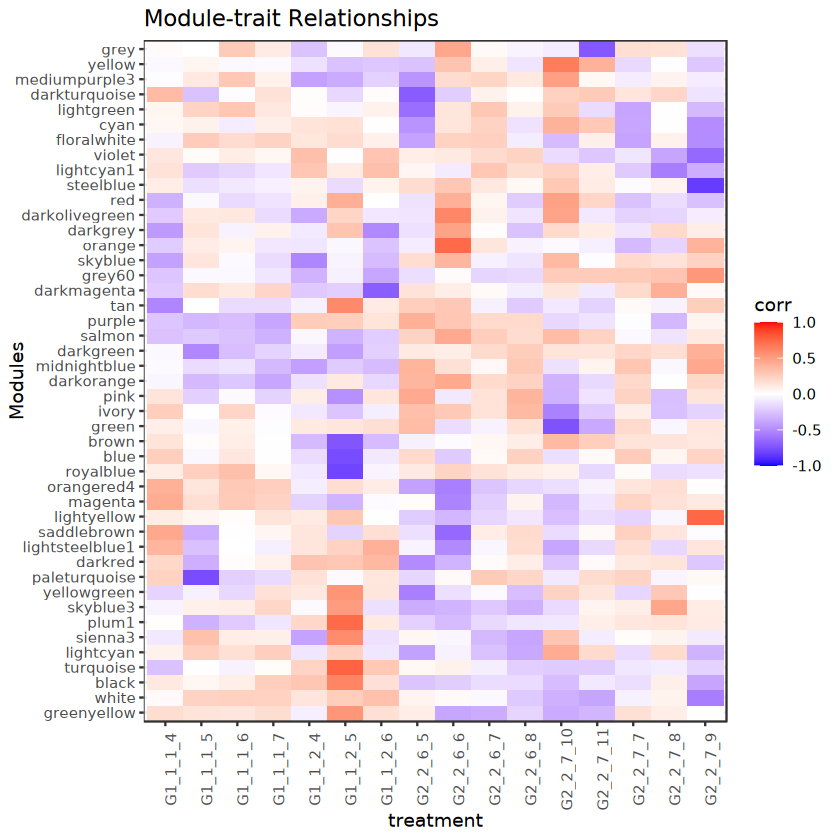

In [27]:
# tidy & plot data
mME = MEs0 %>%
  pivot_longer(-treatment) %>%
  mutate(
    name = gsub("ME", "", name),
    name = factor(name, levels = module_order)
  )

mME %>% ggplot(., aes(x=treatment, y=name, fill=value)) +
  geom_tile() +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(title = "Module-trait Relationships", y = "Modules", fill="corr")

In [28]:
# Save the plot as a PDF file
ggsave("06_WGCNA/module_trait_relationships.pdf",width = 8, height = 10)

# Modify Module Membership File to Only Have Significant Modules

In [32]:
# Read in data
modules <- read.table("06_WGCNA/module_membership.txt", header = TRUE, sep = "\t")

# Covnert to df
modules <- as.data.frame(modules)

# View
head(modules)

,Probe,greenyellow,white,black,turquoise,lightcyan,sienna3,plum1,skyblue3,yellowgreen,⋯,cyan,lightgreen,darkturquoise,mediumpurple3,yellow,grey,treatment,Module,entrez_gene_id,external_gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>,<chr>
1,ENSMUSG00000000001,0.55229621,0.2263257,-0.06552225,0.2886875,-0.3131213,0.30783794,0.0001263238,0.19037918,-0.26165143,⋯,-0.67543184,-0.43610818,-0.71604808,-0.419366192,-0.6443801,0.20599559,NA,tan,14679,Gnai3
2,ENSMUSG00000000028,-0.09481233,-0.1547947,-0.30072175,0.1891965,-0.8228373,-0.41441800,0.1369664885,-0.39740521,-0.49951175,⋯,-0.60649656,-0.53169569,-0.54525555,-0.502945660,-0.5576380,-0.09758113,NA,purple,12544,Cdc45
3,ENSMUSG00000000031,-0.43095943,-0.2349354,-0.32095044,-0.4484298,0.4218830,0.26508286,-0.5649015960,-0.16821297,0.05571242,⋯,0.49531334,0.72139530,0.28664828,0.954152979,0.7538004,0.26513334,NA,mediumpurple3,14955,H19
4,ENSMUSG00000000037,-0.25072585,-0.3682261,-0.19434719,-0.4289547,0.1640407,-0.15561412,0.1234594909,0.09866796,0.23071877,⋯,0.17841913,0.01592102,0.58997201,0.259502266,0.3831939,-0.06600247,NA,blue,107815,Scml2
5,ENSMUSG00000000049,-0.49984548,-0.4618520,-0.65249660,-0.3347883,-0.2792897,-0.11352199,-0.2601837701,-0.47021921,-0.38255670,⋯,-0.07259425,-0.24198338,0.08961941,0.165838091,0.3334224,-0.19839838,NA,blue,11818,Apoh
6,ENSMUSG00000000056,-0.45173551,-0.7024170,-0.63533180,-0.3199402,-0.2273464,-0.06835527,0.2636769988,-0.02459864,0.13866466,⋯,-0.08923281,-0.47475211,0.10572537,0.009546195,0.1213525,-0.29096520,NA,skyblue,67608,Narf


In [33]:
# Remove "ME" prefix from significant modules
significant_modules <- sub("^ME", "", significant_modules)

# View
print(significant_modules)

 [1] "greenyellow"    "white"          "black"          "turquoise"     
 [5] "plum1"          "skyblue3"       "paleturquoise"  "darkred"       
 [9] "lightyellow"    "orangered4"     "royalblue"      "blue"          
[13] "brown"          "ivory"          "darkorange"     "midnightblue"  
[17] "darkgreen"      "salmon"         "purple"         "darkmagenta"   
[21] "grey60"         "skyblue"        "orange"         "darkolivegreen"
[25] "steelblue"      "violet"         "floralwhite"    "lightgreen"    
[29] "darkturquoise" 


In [36]:
# Define the columns to keep
columns_to_keep <- c("Probe", "treatment", "Module", "entrez_gene_id", "external_gene_name", significant_modules)

# Keep only the specified columns
modules <- modules[, columns_to_keep, drop = FALSE]

# View the filtered data
head(modules)

,Probe,treatment,Module,entrez_gene_id,external_gene_name,greenyellow,white,black,turquoise,plum1,⋯,darkmagenta,grey60,skyblue,orange,darkolivegreen,steelblue,violet,floralwhite,lightgreen,darkturquoise
,<chr>,<lgl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,NA,tan,14679,Gnai3,0.55229621,0.2263257,-0.06552225,0.2886875,0.0001263238,⋯,0.14084283,0.1023081,0.311802994,0.24719505,0.1805406,-0.3897085,-0.1189550,-0.21915725,-0.43610818,-0.71604808
2,ENSMUSG00000000028,NA,purple,12544,Cdc45,-0.09481233,-0.1547947,-0.30072175,0.1891965,0.1369664885,⋯,-0.19264559,-0.1103468,0.104636467,0.03342896,-0.1803781,0.1165139,0.2375027,-0.46483099,-0.53169569,-0.54525555
3,ENSMUSG00000000031,NA,mediumpurple3,14955,H19,-0.43095943,-0.2349354,-0.32095044,-0.4484298,-0.5649015960,⋯,0.39945429,0.2603373,0.395481899,0.30612813,0.5099523,0.2060982,-0.1094473,0.25812459,0.72139530,0.28664828
4,ENSMUSG00000000037,NA,blue,107815,Scml2,-0.25072585,-0.3682261,-0.19434719,-0.4289547,0.1234594909,⋯,0.03983615,0.3355153,-0.001035538,-0.12903201,-0.2096256,0.2233409,-0.3970837,-0.04257972,0.01592102,0.58997201
5,ENSMUSG00000000049,NA,blue,11818,Apoh,-0.49984548,-0.4618520,-0.65249660,-0.3347883,-0.2601837701,⋯,0.38233221,0.2761443,0.391118407,-0.20078335,-0.2333499,0.5572453,-0.1564202,-0.40815405,-0.24198338,0.08961941
6,ENSMUSG00000000056,NA,skyblue,67608,Narf,-0.45173551,-0.7024170,-0.63533180,-0.3199402,0.2636769988,⋯,0.31893909,0.6960881,0.563556385,0.09328353,-0.1221260,0.5278084,-0.6232543,-0.56165465,-0.47475211,0.10572537
